In [24]:
import numpy as np
import pandas as pd
import loadData
import monteCarloClass
import time

In [ ]:
data, dataName = loadData.loadData("dt_all.csv")

intensityVariable = "deltaDurS"
sensoryVar = "audNoise"
standardVar = "standardDur"
conflictVar = "conflictDur"
#s
visualStandardVar = "unbiasedVisualStandardDur"
visualTestVar = "unbiasedVisualTestDur"
audioStandardVar = "standardDur"
audioTestVar = "testDurS"
mc_fitter.dataName=dataName



 Total trials before cleaning
: 2226
uniqueSensory: [0.1 1.2] 
 uniqueStandard: [0.5] 
 uniqueConflict: [np.float64(-0.25), np.float64(-0.17), np.float64(-0.08), np.float64(0.0), np.float64(0.08), np.float64(0.17), np.float64(0.25)]
total trials after cleaning: 2226


In [26]:
# Instantiate the Monte Carlo class
mc_fitter = monteCarloClass.OmerMonteCarlo(data)

In [28]:
print("Data shape:", data.shape)
print("\nConflict range:", data["conflictDur"].min(), "to", data["conflictDur"].max())
print("Standard duration:", data["standardDur"].unique())
print("Audio noise levels:", sorted(data["audNoise"].unique()))
print("Visual test duration range:", data["recordedDurVisualTest"].min(), "to", data["recordedDurVisualTest"].max())
print("t_min, t_max:", mc_fitter.t_min, mc_fitter.t_max)

Data shape: (2226, 58)

Conflict range: -0.25 to 0.25
Standard duration: [0.5]
Audio noise levels: [np.float64(0.1), np.float64(1.2)]
Visual test duration range: 0.0244 to 0.8007
t_min, t_max: 0.20841 0.95252


In [29]:
mc_fitter.nSimul = 1000
mc_fitter.optimizationMethod= "bads"  # Use BADS for optimization
mc_fitter.nStart = 1 # Number of random starts for optimization
mc_fitter.modelName = "lognorm"  # Set measurement distribution to Gaussian
mc_fitter.freeP_c= True  # Allow parameter c to be free
mc_fitter.sharedLambda=False # Allow lambda to vary across conditions
mc_fitter.sharedSigma_v=True # Allow sigma to vary across conditions

In [30]:
timeStart = time.time()
print(f"\nFitting Causal Inference Model for {dataName} with {len(mc_fitter.groupedData)} unique conditions")
fittedParams = mc_fitter.fitCausalInferenceMonteCarlo(mc_fitter.groupedData)
print(f"\nFitted parameters for {dataName}: {fittedParams}")
print(f"Time taken to fit: {time.time() - timeStart:.2f} seconds")
mc_fitter.modelFit= fittedParams
mc_fitter.logLikelihood= -mc_fitter.nLLMonteCarloCausal(fittedParams, mc_fitter.groupedData)


Fitting Causal Inference Model for dt_all with 443 unique conditions
Fitting with free p_c parameters for each SNR condition.

Starting 1 optimization attempts using 'bads'...
Model is lognorm


Optimization Attempts: 100%|██████████| 1/1 [04:11<00:00, 251.36s/it]



✅ Best result from 1 attem           spts:
  → Final parameters: [0.15843372 0.27902139 0.65069238 0.96343674 0.57949538 0.11450287
 0.09609558 0.99418931]
  → Final log-likelihood: 1273.204584

Fitted parameters for dt_all: [0.15843372 0.27902139 0.65069238 0.96343674 0.57949538 0.11450287
 0.09609558 0.99418931]
Time taken to fit: 251.36 seconds


# Load Data

In [8]:
# read back the saved file to verify

import os
import json
def loadFitResults(dataName, modelName="lognorm",lapseShared=True):
    participantID = dataName.split('_')[0]
    if lapseShared:
        modelName += "_lapseFix"
    else:
        modelName += "_lapseFree"
    filepath = os.path.join("model_fits", participantID, f"{participantID}_{modelName}_fit.json")
    try:
        with open(filepath, 'r') as f:
            results = json.load(f)
        return results
    except FileNotFoundError:
        print(f"No saved fit results found for {dataName} with model {modelName}.")
        return None

res=loadFitResults(dataName, modelName="lognorm")

No saved fit results found for dt_all with model lognorm_lapseFix.


In [10]:
import os
import numpy as np
import json
def saveFitResultsSingle(fitter,fittedParams, dataName,modelType="lognorm",lapseShared=True):
    participantID = dataName.split('_')[0]
    save_dir = os.path.join("model_fits", participantID)
    
    if lapseShared:
        filename = f"{participantID}_{modelType}_LapseFix_fit.json"
    else:
        filename = f"{participantID}_{modelType}_LapseFree_fit.json"

    filepath = os.path.join(save_dir, filename)

    # make directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # calculate AIC and BIC
    k=len(fittedParams) # number of parameters
    n=len(fitter.groupedData) # number of data points
    fitter.logLikelihood= -fitter.nLLMonteCarloCausal(fittedParams, fitter.groupedData)
    aic= 2*k - 2*fitter.logLikelihood
    bic= np.log(n)*k - 2*fitter.logLikelihood

    

    # store results in a dictionary
    results_dict = {
        "participantID": participantID,
        "modelType": modelType,
        "fittedParams": fittedParams.tolist() if isinstance(fittedParams, np.ndarray) else fittedParams,
        "AIC": float(aic),
        "BIC": float(bic),
        "logLikelihood": fitter.logLikelihood,
        "n_conditions": n

    }


    # Save JSON
    with open(filepath, 'w') as f:
        json.dump(results_dict, f, indent=4)
        
    print(f"✅ Saved fit for {participantID} ({modelType}) to: {filepath}")

#saveFitResultsSingle(fittedParams, dataName, modelType="lognormal")

dataName= mc_fitter.dataName
saveFitResultsSingle(mc_fitter,mc_fitter.modelFit, dataName, modelType="lognorm",lapseShared=False)

✅ Saved fit for default (lognorm) to: model_fits/default/default_lognorm_LapseFree_fit.json


## Simulate data using fitted parameters

In [16]:
mc_fitter.dataName

'default_data'

In [11]:
mc_fitter.simulatedData = mc_fitter.simulateMonteCarloData(fittedParams, mc_fitter.data, nSamples=100)
mc_fitter.simDataFit=mc_fitter.fitMultipleStartingPoints(mc_fitter.simulatedData,1)

"psychometric fit"
mc_fitter.dataFit= mc_fitter.fitMultipleStartingPoints(data,1)

Plotting psychometric curves for Monte Carlo model and data...


AttributeError: 'NoneType' object has no attribute 'x'

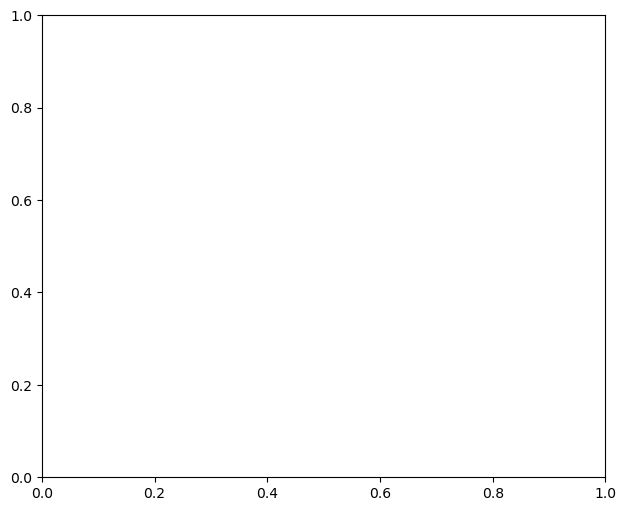

In [23]:
from matplotlib import pyplot as plt
import seaborn as sns
# mc_fitter.dataName = dataName
# mc_fitter.data= data
# mc_fitter.visualStandardVar = visualStandardVar
# mc_fitter.visualTestVar = visualTestVar
# mc_fitter.audioTestVar = audioTestVar

mc_fitter.plotPsychometrics_MC_Data()

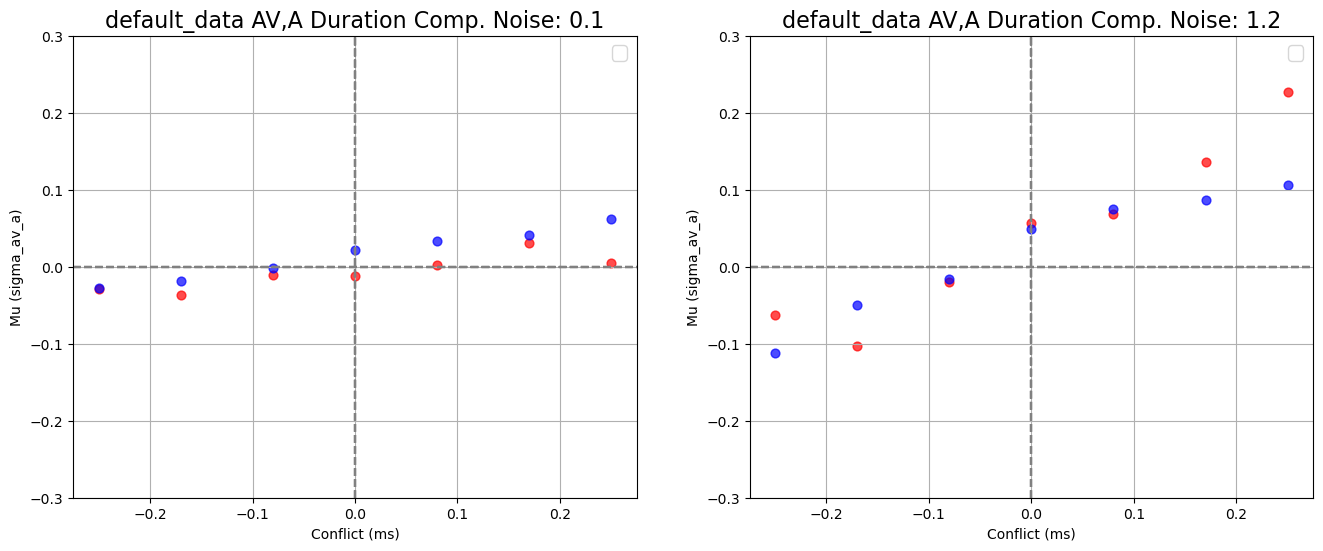

In [13]:

mc_fitter.plot_mu_vs_conflict_MC_vs_Data()

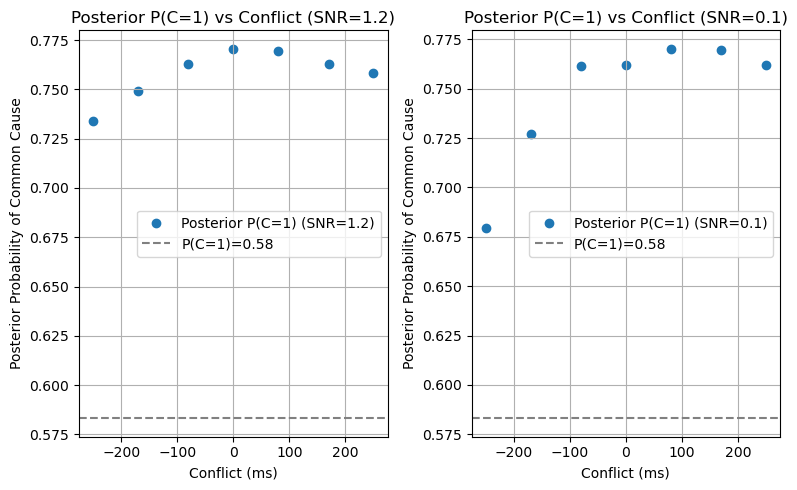

In [14]:
mc_fitter.plot_posterior_vs_conflict(mc_fitter.data, fittedParams)

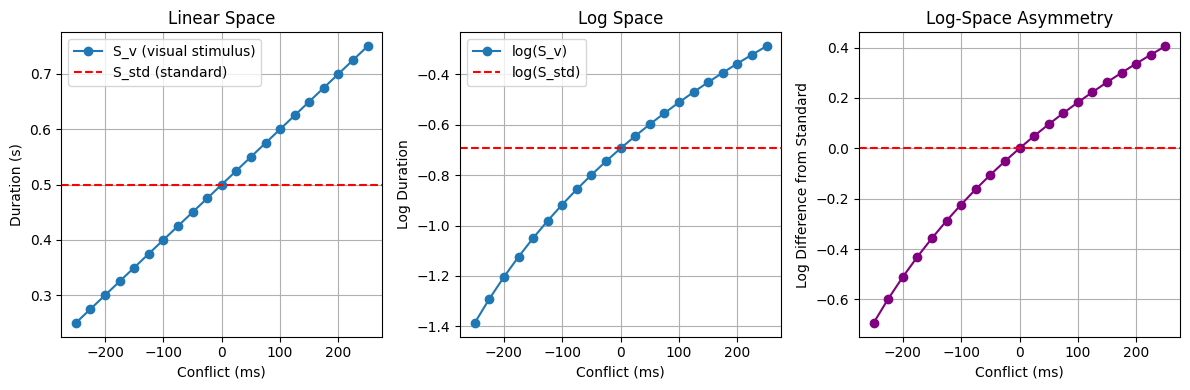

Log differences analysis:
For -250ms conflict: log difference = -0.693
For +250ms conflict: log difference = 0.405
Asymmetry ratio: 1.71


In [30]:
# Diagnostic plot to understand the log-space asymmetry
import matplotlib.pyplot as plt
import numpy as np

# Define the conflict range and standard duration
conflicts = np.linspace(-0.25, 0.25, 21)
S_std = 0.5
S_v_values = S_std + conflicts

# Calculate log differences
log_S_std = np.log(S_std)
log_S_v_values = np.log(S_v_values)
log_differences = log_S_v_values - log_S_std

plt.figure(figsize=(12, 4))

# Plot 1: Linear space
plt.subplot(1, 3, 1)
plt.plot(conflicts * 1000, S_v_values, 'o-', label='S_v (visual stimulus)')
plt.axhline(y=S_std, color='red', linestyle='--', label='S_std (standard)')
plt.xlabel('Conflict (ms)')
plt.ylabel('Duration (s)')
plt.title('Linear Space')
plt.legend()
plt.grid(True)

# Plot 2: Log space
plt.subplot(1, 3, 2)
plt.plot(conflicts * 1000, log_S_v_values, 'o-', label='log(S_v)')
plt.axhline(y=log_S_std, color='red', linestyle='--', label='log(S_std)')
plt.xlabel('Conflict (ms)')
plt.ylabel('Log Duration')
plt.title('Log Space')
plt.legend()
plt.grid(True)

# Plot 3: Log differences (this shows the asymmetry!)
plt.subplot(1, 3, 3)
plt.plot(conflicts * 1000, log_differences, 'o-', color='purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Conflict (ms)')
plt.ylabel('Log Difference from Standard')
plt.title('Log-Space Asymmetry')
plt.grid(True)

plt.tight_layout()
plt.show()

print("Log differences analysis:")
print(f"For -250ms conflict: log difference = {log_differences[0]:.3f}")
print(f"For +250ms conflict: log difference = {log_differences[-1]:.3f}")
print(f"Asymmetry ratio: {abs(log_differences[0]) / abs(log_differences[-1]):.2f}")

# N simulations values to try

In [13]:
nSimul_values = [100,500,1000,2000]
results = []
mc_fitter.modelName = "lognorm"  # Set measurement distribution to lognormal

mc_fitter.nStart = 1  # Number of random starts for optimization
mc_fitter.optimizationMethod = "bads"  # Use BADS for optimization
for nSimul in nSimul_values:
    mc_fitter.nSimul = nSimul
    fittedParams = mc_fitter.fitCausalInferenceMonteCarlo(mc_fitter.groupedData)
    log_likelihood = -mc_fitter.nLLMonteCarloCausal(fittedParams, mc_fitter.groupedData)
    results.append((nSimul, fittedParams, log_likelihood))

# Compare results
for nSimul, params, ll in results:
    print(f"nSimul: {nSimul}, Log-Likelihood: {ll:.4f}, Params: {params}")


Starting 1 optimization attempts using 'bads'...


Optimization Attempts: 100%|██████████| 1/1 [03:36<00:00, 216.86s/it]



✅ Best result from 1 attempts:
  → Final parameters: [0.14948024 0.16048542 0.34457541 0.89012177 0.52122876 1.34088237]
  → Final log-likelihood: 1108.433234

Starting 1 optimization attempts using 'bads'...


Optimization Attempts: 100%|██████████| 1/1 [02:31<00:00, 151.24s/it]



✅ Best result from 1 attempts:
  → Final parameters: [0.09159355 0.17508314 0.31008884 0.62332083 0.76331443 0.1       ]
  → Final log-likelihood: 1102.912807

Starting 1 optimization attempts using 'bads'...


Optimization Attempts: 100%|██████████| 1/1 [20:31<00:00, 1231.68s/it]



✅ Best result from 1 attempts:
  → Final parameters: [0.1116563  0.16926374 0.30757191 0.70794918 0.66368762 0.80023083]
  → Final log-likelihood: 1101.185697

Starting 1 optimization attempts using 'bads'...


Optimization Attempts: 100%|██████████| 1/1 [17:30<00:00, 1050.18s/it]



✅ Best result from 1 attempts:
  → Final parameters: [0.09424064 0.17950971 0.3137875  0.67125069 0.61873052 1.33178849]
  → Final log-likelihood: 1101.025804
nSimul: 100, Log-Likelihood: -1109.7755, Params: [0.14948024 0.16048542 0.34457541 0.89012177 0.52122876 0.34457541]
nSimul: 500, Log-Likelihood: -1101.3616, Params: [0.09159355 0.17508314 0.31008884 0.62332083 0.76331443 0.31008884]
nSimul: 1000, Log-Likelihood: -1100.4236, Params: [0.1116563  0.16926374 0.30757191 0.70794918 0.66368762 0.30757191]
nSimul: 2000, Log-Likelihood: -1102.2085, Params: [0.09424064 0.17950971 0.3137875  0.67125069 0.61873052 0.3137875 ]


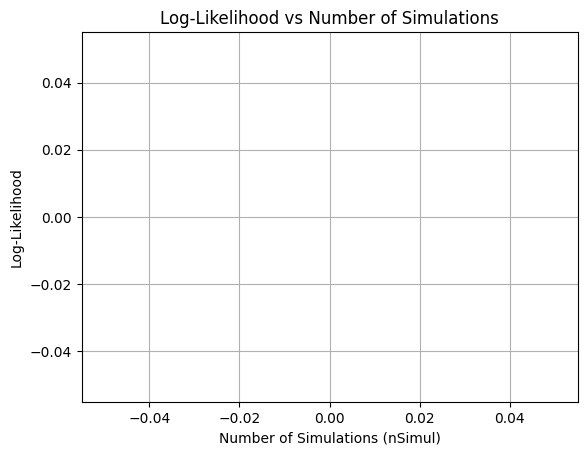

In [18]:
#plot the log likelihood vs nSimul
plt.figure()
plt.plot([r[0] for r in results], [r[2] for r in results], marker='o')
plt.xlabel('Number of Simulations (nSimul)')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs Number of Simulations')
plt.grid()
plt.show()

# Number of Starting Points for Optimization

In [15]:
nStartValues = [5,10,20]
results = []
mc_fitter.modelName = "lognorm"  # Set measurement distribution to lognormal

mc_fitter.nSimul = 1000
mc_fitter.optimizationMethod = "bads"  # Use BADS for optimization
for nStart in nStartValues:
    mc_fitter.nStart = nStart
    fittedParams = mc_fitter.fitCausalInferenceMonteCarlo(mc_fitter.groupedData)
    log_likelihood = -mc_fitter.nLLMonteCarloCausal(fittedParams, mc_fitter.groupedData)
    results.append((nSimul, fittedParams, log_likelihood))
    

# # Compare results
# for nSimul, params, ll in results:
#     print(f"nSimul: {nSimul}, Log-Likelihood: {ll:.4f}, Params: {params}")
#plot the log likelihood vs nStart
plt.figure()
plt.plot([r[0] for r in results], [r[2] for r in results], marker='o')
plt.xlabel('Number of Starting Points (nStart)')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs Number of Starting Points')
plt.grid()
plt.show()


Starting 5 optimization attempts using 'bads'...


Optimization Attempts:  80%|████████  | 4/5 [16:43<04:10, 250.94s/it]


KeyboardInterrupt: 